+ [LightweightMMM Documentation](https://lightweight-mmm.readthedocs.io/en/latest/index.html)
+ [Github](https://github.com/google/lightweight_mmm/)
    * [Simple End to End Demo](https://github.com/google/lightweight_mmm/blob/main/examples/simple_end_to_end_demo.ipynb)
    * [End to End Demo with Multiple Geos](https://github.com/google/lightweight_mmm/blob/main/examples/end_to_end_demo_with_multiple_geos.ipynb)
    

+ [Tunable Lightweight MMM: using google’s new marketing mix model with added functions.](https://medium.com/@xijianlim/tunable-lightweight-mmm-using-googles-new-mixed-marketing-models-with-added-functions-eb89962205b2)
    + Colab notebook: [Using google's Lightweight MMM packag with channel/adstock tuning and exporting modelled response curves](https://colab.research.google.com/drive/1zKHmT_CR6AmVbH-4PdsmUJdumMadcmrO#scrollTo=WcYeesq4w3jT)

    
+ [How Google LightweightMMM Works](https://getrecast.com/google-lightweightmmm/)


+ [Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns](https://juanitorduz.github.io/pymc_mmm/)

In [1]:
### INSTALACIÓN
#
# download jaxlib from https://whls.blob.core.windows.net/unstable/index.html
# !pip install <jaxlib_whl>

# !pip install jaxlib-0.4.11+cuda.cudnn89-cp311-cp311-win_amd64.whl
# !pip install jax

# !pip install lightweight_mmm

In [2]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro

c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import jax

jax.local_device_count()

1

In [ ]:
# numpyro.set_host_device_count(2)

In [10]:
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
from lightweight_mmm import plot

In [4]:
# Let's assume we have the following datasets with the following shapes (we use
# the `simulate_dummy_data` function in utils for this example):
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=160,
    n_media_channels=3,
    n_extra_features=2,
    geos=5) # Or geos=1 for national model

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
data_size = 160

# Simple split of the data based on time.
split_point = data_size - data_size // 10
media_data_train = media_data[:split_point, :]
target_train = target[:split_point]
extra_features_train = extra_features[:split_point, :]
extra_features_test = extra_features[split_point:, :]
unscaled_costs = costs

# Scale data
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(
    divide_operation=jnp.mean)
# scale cost up by N since fit() will divide it by number of time periods
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(
    extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(unscaled_costs)

In [7]:
# Fit model.
mmm = lightweight_mmm.LightweightMMM()
mmm.fit(media=media_data,
        extra_features=extra_features,
        media_prior=costs,
        target=target,
        number_warmup=1000,
        number_samples=1000,
        number_chains=2)

c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\lightweight_mmm\lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [05:15<00:00,  6.34it/s, 1023 steps of size 6.90e-03. acc. prob=0.94]


In [9]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
            channel_coef_media[0,0]      3.74      2.02      3.55      0.27      6.62    148.47      1.02
            channel_coef_media[1,0]      6.82      2.88      7.29      2.55     10.67      7.07      1.62
            channel_coef_media[2,0]     12.44      1.60     12.51      9.95     14.97     11.71      1.32
           coef_extra_features[0,0]     -1.74      0.19     -1.75     -2.04     -1.41   1514.42      1.01
           coef_extra_features[0,1]     -1.72      0.18     -1.72     -2.03     -1.43   1932.66      1.00
           coef_extra_features[0,2]     -1.74      0.19     -1.74     -2.04     -1.44   1653.38      1.01
           coef_extra_features[0,3]     -1.61      0.20     -1.61     -1.93     -1.28   1717.31      1.01
           coef_extra_features[0,4]     -1.78      0.18     -1.78     -2.07     -1.48   2159.58      1.01
           coef_extra_features[1,0]     -1.16

In [25]:
mmm.trace['coef_media'][0].shape

(3, 5)

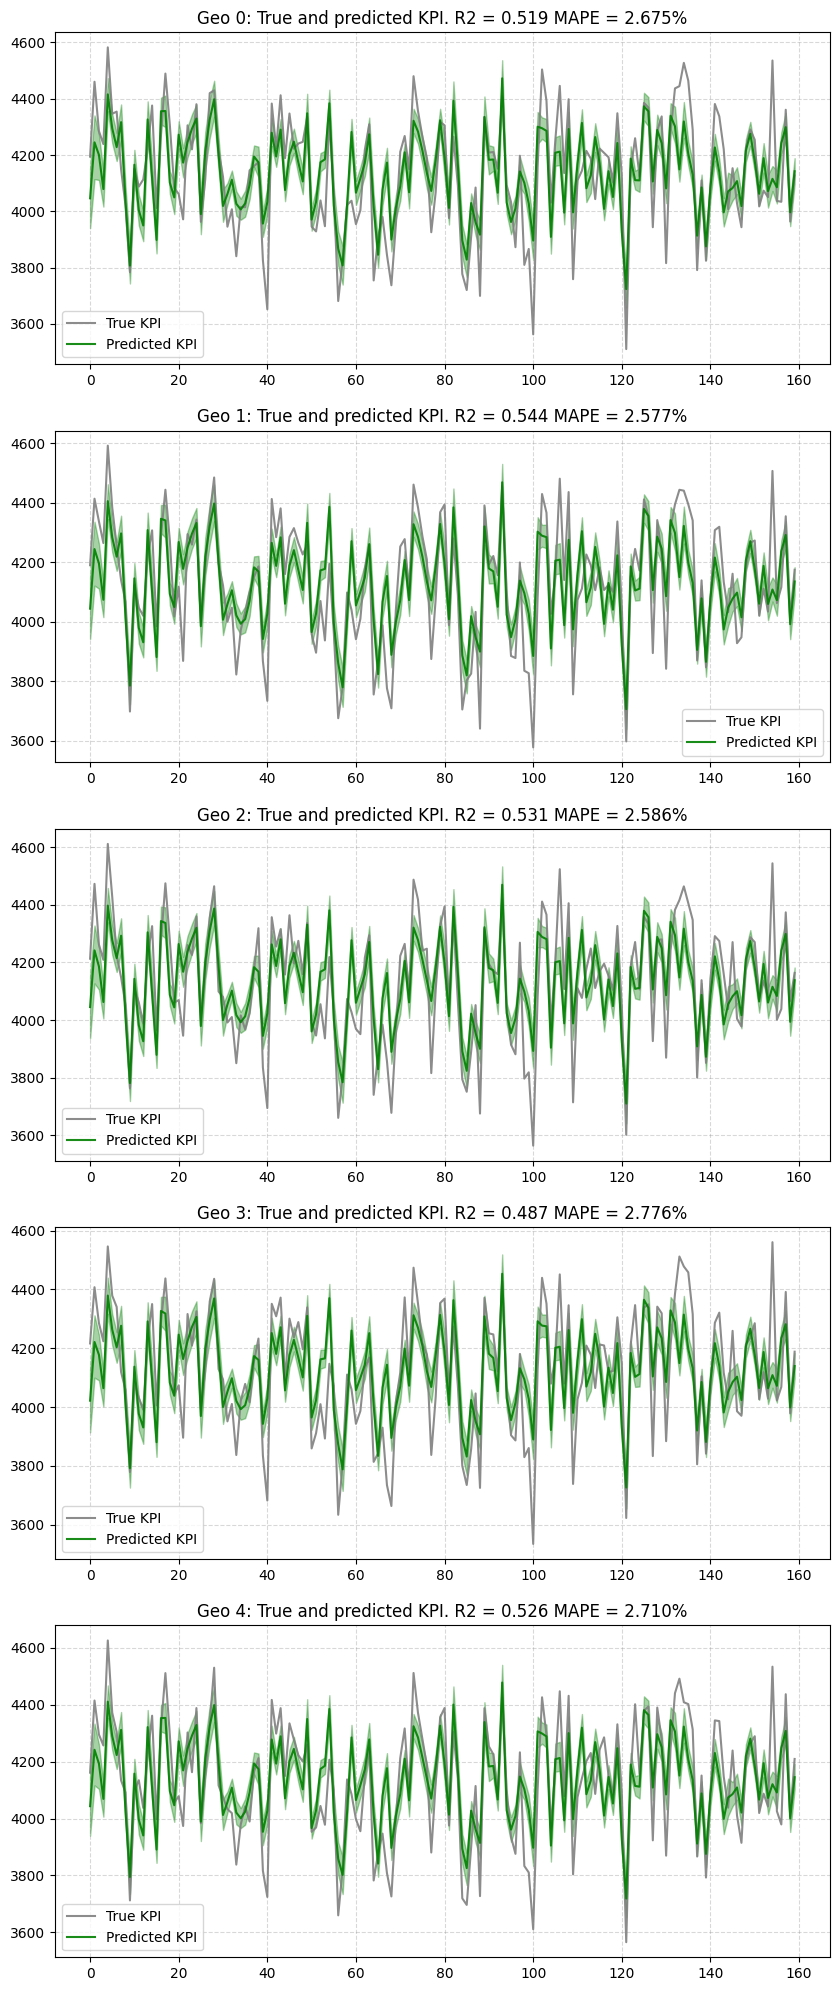

In [13]:
plot.plot_model_fit(media_mix_model=mmm, target_scaler=target_scaler)

In [16]:
prediction = mmm.predict(
    media=media_data,
    extra_features=extra_features,
    target_scaler=target_scaler
)

In [17]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=media_names)

NameError: name 'media_names' is not defined

In [ ]:
media_effect_hat, roi_hat = mmm.get_posterior_metrics()

In [ ]:
plot.plot_bars_media_metrics(metric=media_effect_hat, channel_names=media_names)

In [ ]:
plot.plot_bars_media_metrics(metric=roi_hat, channel_names=media_names)

In [ ]:
# Run media optimization.
budget = 40 # your budget here
prices = np.array([0.1, 0.11, 0.12])
extra_features_test = extra_features_scaler.transform(extra_features_test)
solution = optimize_media.find_optimal_budgets(
    n_time_periods=extra_features_test.shape[0],
    media_mix_model=mmm,
    budget=budget,
    extra_features=extra_features_test,
    prices=prices)

In [ ]:
utils.save_model(mmm, file_path='../../outputs/files/lw_mmm')

In [ ]:
utils.load_model(file_path: ''../../outputs/files/lw_mmm'')